In [1]:
import numpy as np
import numba as nb
from numba import njit, prange
#from tqdm.notebook import tqdm, trange
import matplotlib as mpl
from matplotlib import pyplot as plt


In [2]:
@njit
def nb_seed(seed):
    np.random.seed(seed)

In [3]:
nb_seed(123456)

In [4]:
@njit
def dynamic(α:float, s:int, z:int, r:int, τ:float):
    c = s*z/(s+z+r)
    dτ = np.random.exponential(1/((1+α)*c))
    if np.random.uniform(0, 1) < α/(α+1):  # kill
        return s, z-1, r+1, dτ+τ
    else:  # bite
        return s-1, z+1, r, dτ+τ


In [5]:
@njit
def run_dense(s0:int, z0:int, r0:int, α:float):
    states = np.empty((s0*2, 4), dtype=np.float64)
    states[0] = s0, z0, r0, 0  # S,Z,R,τ
    i = 0
    while states[i, 0] != 0 and states[i, 1] != 0:
        s, z, r, τ = states[i]
        i += 1
        states[i] = dynamic(α, s, z, r, τ)
    return states[:i+1]


In [6]:
def plt_dense_event(states:np.ndarray):
    plt.axes(xlabel='τ',ylabel='N')
    plt.plot(states[:,3],states[:,0],label='S')
    plt.plot(states[:,3],states[:,1],label='Z')
    plt.plot(states[:,3],states[:,2],label='R')
    plt.legend()
    plt.draw()

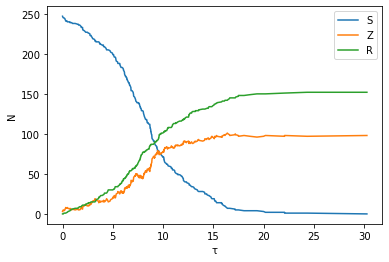

In [7]:
res=run_dense(247,3,0,0.6)
plt_dense_event(res)

In [8]:
@njit(parallel=True)
def alpha_scan(alpha_list: np.ndarray, N_trail: int, S0: int, Z0: int):
    N_alpha = alpha_list.shape[0]
    # counter for # of extinction of zombies in N trails
    N_ext = np.zeros(N_alpha)
    for i in prange(N_alpha):
        α = alpha_list[i]
        for _ in range(N_trail):
            Z_fin = run_dense(S0, Z0, 0, α)[-1, 1]
            if Z_fin == 0:
                N_ext[i] += 1
    return N_ext/N_trail


In [9]:
alpha_list=np.linspace(0,1)
P_ext=alpha_scan(alpha_list,1000,9999,1)

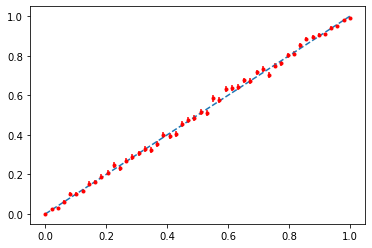

In [10]:
plt.plot((0, 1), (0, 1), '--')
err_bar = np.sqrt(P_ext*(1-P_ext)/1000)
plt.errorbar(alpha_list, P_ext, yerr=err_bar, fmt='.', color='red')
plt.draw()
